In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.001, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [15]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [16]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [46]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [18]:
x0 |> size

(28, 28, 128)

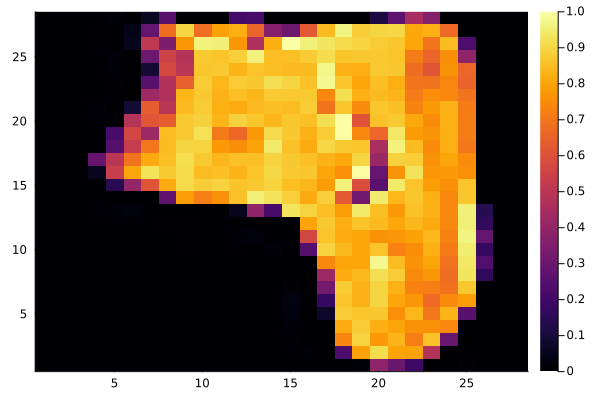

In [20]:
heatmap(x0[:,:,1])

# Test conventional network

In [27]:
model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),  # 100_480 parameters
    layer_4 = Dense(128 => 10),         # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [28]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.083775096 0.058567498 … 0.079856336 0.044404358; -0.06898064 -0.11790769 … 0.018660922 -0.008068705; … ; 0.100254714 0.028090617 … 0.012544866 -0.03064143; 0.08437972 -0.027003136 … 0.076104924 -2.754987f-5], bias = Float32[-0.016158849, -0.016891351, 0.0077304714, 0.023463776, 0.015564824, -0.006406831, 0.033348776, -0.0019756428, -0.022636771, 0.010966067  …  -0.02596117, -0.02608088, 0.013837733, 0.0014306307, 0.008929274, 0.0034274799, 0.019304888, 0.017156538, -0.029783884, -0.007927494]), layer_4 = (weight = Float32[-0.112290844 -0.063694365 … -0.03334412 -0.005785234; 0.10546727 -0.13637327 … -0.027950792 -0.08730433; … ; -0.0034854447 -0.052735478 … 0.11120662 -0.043703236; 0.009805881 -0.005822099 … 0.10795013 -0.14993675], bias = Float32[0.052961256, -0.0027256366, 0.06930969, -0.029723844, -0.006110408, 0.039441694, -0.0758

In [43]:
yp, _ = model(x0, ps, st);

In [44]:
yp |> size

(10, 128)

In [49]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [50]:
loss_function(x0, y0, model, ps, st)

2.84977f0

In [51]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.8497698f0, 2.3157365f0, 1.7866548f0, 1.6081502f0, 1.2932224f0, 1.0307795f0, 1.1170993f0, 1.0776668f0, 1.0947087f0, 0.97735894f0  …  0.12412126f0, 0.0983385f0, 0.0817174f0, 0.24793278f0, 0.13357614f0, 0.1767902f0, 0.19749433f0, 0.1477754f0, 0.062110767f0, 0.103301406f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.2562584; 0.36193553; … ; 0.35693678; 0.42359674;;], scale = Float32[0.73535013; 0.6310324; … ; 0.7043018; 0.5756777;;]), layer_3 = (weight = Float32[-0.028861847 0.107116506 … 0.07991702 0.07406044; -0.0024979264 -0.04040274 … 0.022332119 0.061734248; … ; 0.16091612 0.0916626 … -0.00024240838 0.0033808637; 0.13379385 0.01599282 … 0.0804522 0.029511802], bias = Float32[-0.06779209, -0.058769386, 0.047286298, -0.03328045, 0.033971176, -0.09772068, 0.067933924, -0.04697224, -0.1583284, -0.03192455  …  -0.06506683, -0.025048826, -0.027660271, -0.0655749, -0.023959668, -0.052332032, -0.07473771, -0.031164883, -0.08283297, -0.08561806]), layer_4 = (weight = Float32[0

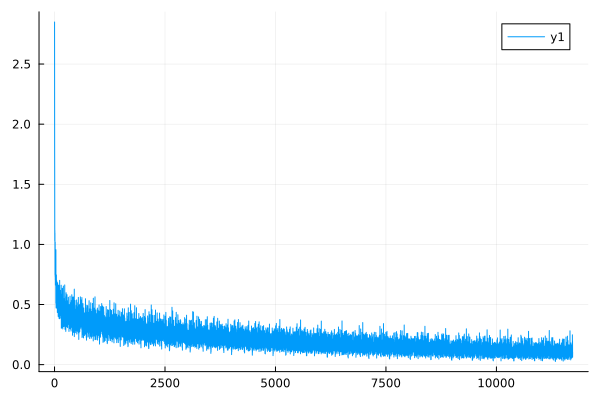

In [52]:
plot(losses)

In [58]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [64]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [65]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0502

In [66]:
test(model, test_loader, pst, stt)

0.8866

# Test Phasor network

In [68]:
import .PhasorNetworks: default_bias

In [71]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 10, soft_angle, init_bias=default_bias),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#33),
    layer_4 = WrappedFunction(#34),
    layer_5 = PhasorDense(
        dense = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 103_476 parameters,
          #        plus 0 states.

In [72]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = (weight = Float32[0.0044129053 0.043673083 … 0.021648785 -0.061477195; -0.053004306 0.05363333 … -0.022728052 -0.05287039; … ; -0.0010313725 0.054895226 … -0.05608068 -0.038746834; 0.00645689 -0.029039104 … -0.020992404 -0.040476903],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (dense = (weight = Float32[0.10470235 -0.013714784 … -0.10171921 -0.0011845059; -0.073227026 0.1439858 … -0.11652868 -0.118332855; … ; 0.102934755 0.11811048 … -0.07018316 -0.12981698; 0.039996874 -0.0019218838 … -0.024186777 0.14554662],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [74]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.11782554 -0.0123490365 … 0.045078184 -0.18358487; 0.037466303 0.028553125 … 0.17372072 0.059455875; … ; -0.035607003 -0.15070722 … -0.2010171 0.02658058; -0.2449469 -0.39084086 … -0.3403051 0.12485657], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense_real = NamedTuple(), dense_imag = NamedTuple()), layer_6 = (dense_real = NamedTuple(), dense_imag = NamedTuple())))

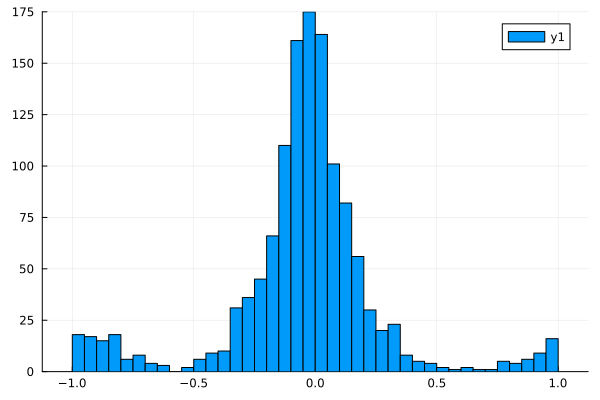

In [75]:
histogram(cdev(vec(yp0)))

In [78]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = quadrature_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [79]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.37707433f0

In [91]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[0.37707433f0, 0.20446031f0, 0.15772124f0, 0.1294008f0, 0.10505017f0, 0.091305956f0, 0.08491532f0, 0.08346215f0, 0.08562883f0, 0.08070913f0  …  0.014238765f0, 0.011767441f0, 0.008582475f0, 0.016741848f0, 0.016044084f0, 0.01374167f0, 0.016374977f0, 0.01741619f0, 0.010915456f0, 0.013824313f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.109866455; -0.09026752; … ; -0.0052409596; 0.1157549;;], scale = Float32[0.9391878; 0.9330233; … ; 0.92461056; 0.79636604;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = (weight = Float32[0.053903043 0.09870861 … 0.07554486 0.012226259; -0.086422905 0.013476209 … -0.06858415 -0.1312169; … ; 0.049532976 0.10614844 … 0.021049893 -0.009038355; 0.028448284 0.0054273787 … -0.00027783698 0.05791117],), bias = (bias_real = Float32[1.22151, 1.0400026, 1.0301839, 1.2764461, 0.73738205, 1.2719176, 1.0994903, 1.1783909, 0.93272907, 0.9187026  …  1.1322328, 1.1577678, 1.101583, 1.1600504, 0.88871926, 1.1496385, 1.114313, 1.093082

In [92]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.22151, 1.0400026, 1.0301839, 1.2764461, 0.73738205, 1.2719176, 1.0994903, 1.1783909, 0.93272907, 0.9187026  …  1.1322328, 1.1577678, 1.101583, 1.1600504, 0.88871926, 1.1496385, 1.114313, 1.0930824, 0.9175456, 1.1061196], bias_imag = Float32[-0.124023065, 0.09969372, 0.010674702, 0.09205989, 0.13839433, -0.16783641, -0.09499648, -0.20626107, 0.0887227, 0.14178218  …  -0.23901932, -0.0925672, -0.09735049, -0.046940867, 0.12835774, -0.012320111, 0.12749644, -0.06297604, -0.030411763, -0.10250353])

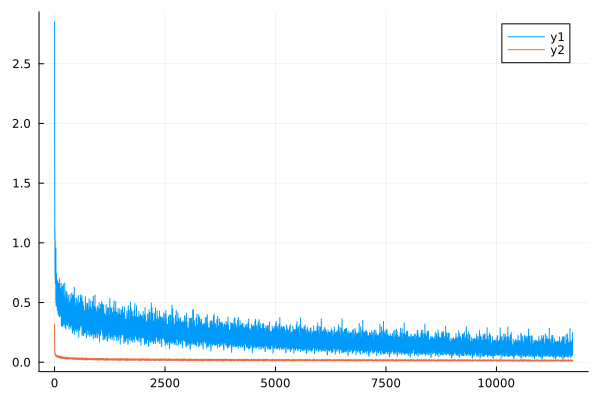

In [93]:
plot(losses)
plot!(log1p.(losses_f))

In [94]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_quadrature(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [95]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8808

# Test spiking behavior

In [96]:
spk_model = Chain(FlattenLayer(),
                    LayerNorm((28^2,)),
                    x -> tanh.(x), 
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
                PhasorDense(128 => 10, soft_angle, init_bias=default_bias),
                )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#37),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        dense = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 103_476 parameters,
          #        plus 0 states.

In [97]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = (weight = Float32[-0.050351936 0.059024602 … -0.0003952551 0.016652886; -0.019104103 -0.036714774 … 0.022187032 -0.04170588; … ; 0.038716253 0.004182079 … 0.05015119 -0.055386093; 0.034011662 0.050295826 … -0.02130638 -0.022492861],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (dense = (weight = Float32[0.07760824 0.12730755 … 0.033512916 0.054015998; -0.12091282 0.11568684 … -0.0039662076 0.011893166; … ; 0.042534683 -0.14465417 … 0.079755366 -0.08973665; 0.10395313 0.06024916 … -0.02536984 -0.059662495],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [98]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[1.9996275, 2.0000722, 2.0001302, 2.0003524, 2.000451, 2.0001328, 2.0002174, 2.0000694, 2.000158, 1.9999394  …  20.501926, 21.181822, 21.018099, 21.495605, 21.018276, 21.491499, 20.641499, 21.081219, 20.657145, 21.063665], (10, 128), 1280, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), l

In [99]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[1.9996275, 2.0000722, 2.0001302, 2.0003524, 2.000451, 2.0001328, 2.0002174, 2.0000694, 2.000158, 1.9999394  …  20.501926, 21.181822, 21.018099, 21.495605, 21.018276, 21.491499, 20.641499, 21.081219, 20.657145, 21.063665], (10, 128), 1280, 0.5f0)

In [100]:
ys0.t_span

(0.0f0, 20.0f0)

In [41]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 124), CartesianIndex(2, 124), CartesianIndex(1, 125), CartesianIndex(2, 125), CartesianIndex(1, 126), CartesianIndex(2, 126), CartesianIndex(1, 127), CartesianIndex(2, 127), CartesianIndex(1, 128), CartesianIndex(2, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  247, 248, 249, 250, 251, 252, 253, 254, 255, 256], Float32[2.026862, 2.0111399, 2.026862, 2.0111399, 2.0268276, 2.0111437, 2.026862, 2.0111399, 2.026862, 2.0111399  …  20.987972, 21.484526, 21.482346, 21.489006, 21.002304, 21.252728, 21.486706, 21.0917, 21.016745, 21.124039], (2, 128), 256, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTupl

In [105]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, :, n_batches), dims=2) ./ num
    return acc
end

fmnist_spiking_accuracy (generic function with 1 method)

In [106]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

21×1 Matrix{Float64}:
 0.1
 0.1756
 0.7414
 0.8288
 0.8527
 0.8641
 0.8702
 0.8734
 0.8752
 0.8767
 0.8786
 0.8781
 0.8783
 0.8786
 0.8801
 0.8795
 0.8808
 0.8803
 0.8806
 0.0802
 0.079

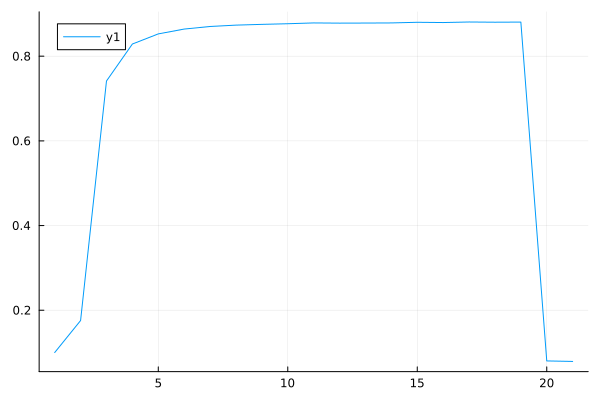

In [107]:
plot(spk_a)